# KNN text classification from ICLR 2018 reviews

Using ICLR 2018 reviews from openreview, KNN was used in this notebook, using the decision as label for a review

In [1]:
import pandas as pd
import ast # Library to parse code, since replies were saved as a list format in the csv
from collections import Counter
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from matplotlib import pyplot as plt
import string
import re
import numpy as np

from collections import Counter

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/eisen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eisen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Path to data that contains csv names for iclr conferences

In [2]:
path_to_data = "iclr_urls.csv"
iclr_conf_data = pd.read_csv(path_to_data) 
iclr_conf_data.head()

,conference,conference_url,n_papers,comments
0,iclr2013_conference,ICLR.cc/2013/conference/-/submission,67,NaN
1,iclr2014_conference,ICLR.cc/2014/conference/-/submission,69,without decisions data
2,iclr2014_workshop,ICLR.cc/2014/workshop/-/submission,19,without decision data
3,iclr2016_workshop,ICLR.cc/2016/workshop/-/submission,125,without decision data
4,iclr2017_conference,ICLR.cc/2017/conference/-/paper.*/acceptance,490,NaN


#### Showing conference where data is available from the iclr_ulrs.csv

In [3]:
iclr_conf_data['conference']

0              iclr2013_conference
1              iclr2014_conference
2                iclr2014_workshop
3                iclr2016_workshop
4              iclr2017_conference
5                iclr2017_workshop
6     iclr2018_conference_decision
7       iclr2018_workshop_decision
8     iclr2019_conference_decision
9         iclr2019_workshop_drlmsp
10           iclr2019_workshop_rml
11           iclr2019_workshop_lld
12        iclr2019_workshop_dgmhsd
Name: conference, dtype: object

#### Data for iclr 2018 is divided between the conference and its workshops

In [4]:
iclr_conf_data['conference'].iloc[6]

'iclr2018_conference_decision'

#### Using ICLR 2018 conference data 

In [5]:
iclr18_dataset = pd.read_csv(iclr_conf_data['conference'].iloc[6]+".csv").dropna()
iclr18_dataset.head()

,title,authors,emails,decision,abstract,pdf,replies
0,Multi-Scale Dense Networks for Resource Effici...,"['Gao Huang', 'Danlu Chen', 'Tianhong Li', 'Fe...","['gh349@cornell.edu', 'taineleau@gmail.com', '...",Accept (Oral),In this paper we investigate image classificat...,/pdf/b92cc4191e13816cacce262b4e421aac1052ec10.pdf,"[[('title', 'Reproducibility challenge report'..."
1,Training and Inference with Integers in Deep N...,"['Shuang Wu', 'Guoqi Li', 'Feng Chen', 'Luping...","['wus15@mails.tsinghua.edu.cn', 'liguoqi@mail....",Accept (Oral),Researches on deep neural networks with discre...,/pdf/516345e75eb2cf918642c571d05976a33898d715.pdf,"[[('title', 'have you try (mod P) congruence c..."
2,Soft Actor-Critic: Off-Policy Maximum Entropy ...,"['Tuomas Haarnoja', 'Aurick Zhou', 'Pieter Abb...","['haarnoja@berkeley.edu', 'azhou42@berkeley.ed...",Invite to Workshop Track,Model-free deep reinforcement learning (RL) al...,/pdf/e1eb879881dc4bb5154c254d75b0bd9de48c879c.pdf,"[[('title', 'ICLR 2018 Conference Acceptance D..."
3,Synthetic and Natural Noise Both Break Neural ...,"['Yonatan Belinkov', 'Yonatan Bisk']","['belinkov@mit.edu', 'ybisk@yonatanbisk.com']",Accept (Oral),Character-based neural machine translation (NM...,/pdf/76dfbeba1cf42abb13f7dc148795613794e38195.pdf,"[[('title', 'ICLR 2018 Conference Acceptance D..."
4,Reinforcement Learning from Imperfect Demonstr...,"['Yang Gao', 'Huazhe(Harry) Xu', 'Ji Lin', 'Fi...","['yg@eecs.berkeley.edu', 'huazhe_xu@eecs.berke...",Invite to Workshop Track,Robust real-world learning should benefit fro...,/pdf/472dfbe7059af65461c84e0e210c27f8245c9421.pdf,"[[('title', 'ICLR 2018 Conference Acceptance D..."


#### 911 papers are avaible from the openreview website

In [6]:
replies = iclr18_dataset['replies']
print("Number of papers: " + str(len(replies))) 
replies[:5]

Number of papers: 911


0    [[('title', 'Reproducibility challenge report'...
1    [[('title', 'have you try (mod P) congruence c...
2    [[('title', 'ICLR 2018 Conference Acceptance D...
3    [[('title', 'ICLR 2018 Conference Acceptance D...
4    [[('title', 'ICLR 2018 Conference Acceptance D...
Name: replies, dtype: object

#### There are only 4 possible classes to tag reviews,classes differ a lot in its numbers

In [7]:
decision_options = Counter(iclr18_dataset['decision'])
decision_options

Counter({'Accept (Oral)': 23,
         'Invite to Workshop Track': 89,
         'Reject': 486,
         'Accept (Poster)': 313})

In [8]:
decision_labels = {"Accept (Oral)": 0,
         "Invite to Workshop Track": 1,
         "Reject": 2,
         "Accept (Poster)": 3}
decision_labels

{'Accept (Oral)': 0,
 'Invite to Workshop Track': 1,
 'Reject': 2,
 'Accept (Poster)': 3}

In [9]:
def match_reviews_and_decision(df_venue, labels):
  """Creates and lists of lists containing a review an its decision
  
  Args:
    df_venue (pandas dataframe): Contains data from a venue where each row represents
    a paper that have title, authors, emails, decision, abstract, pdf and replies fields.
    labels (dictionary): Maps a string to a number that encodes the  decision as an integer
  Returns:
    A lists of pairs where the first elements are the decision encoded with the labels
    and the second elements is the review.
    
  """

#   print(df_venue.head())
  
  decision_review = []
  for index, row in df_venue.iterrows():
    comments = ast.literal_eval(row['replies'])
    for comment in comments:
      if comment[1][0] == "rating": # They called reviews as rating
        decision_review.append([labels[row['decision']],comment[1][1]])
  return decision_review

In [10]:
decision_review = match_reviews_and_decision(iclr18_dataset, decision_labels)
len(decision_review)

2748

#### Defining cleaning method includes punctuation marks, stop words &amp; digits.

In [11]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    processed = re.sub(r"\d+","",normalized)
    y = processed.split()
    return y

#### Cleaning the reviews and extracting tf-idf features using scikit-learn library

In [12]:
def preprocess_data(df_venue):
  """Does the preprocessing applying the clean function and the
  TfidVectorizer using the english stopwords
  
  Args:
    df_venue (pandas dataframe): Contains data from a venue where each row represents
    a paper that have title, authors, emails, decision, abstract, pdf and replies fields.
    
  Returns:
    X (sparse matrix, [n_samples, n_features]): Tf-idf-weighted document-term matrix.
    y (lists of integers): labels encoded as integers.

  """
  
  train_clean_sentences = []
  y = np.array([y[0] for y in decision_review])

  for line in decision_review:
    line = line[1].strip()
    cleaned = clean(line)
    cleaned = ' '.join(cleaned)
    train_clean_sentences.append(cleaned)
    
  vectorizer = TfidfVectorizer(stop_words='english')
  
  X = vectorizer.fit_transform(train_clean_sentences)
  
  return X, y

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    y_true = [int(x) for x in y_true]
    y_pred = [int(x) for x in y_pred]
    
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [14]:
X, y = preprocess_data(decision_review)

In [18]:
X.shape

(2748, 14)

In [19]:
len(y)

2748

#### Setting k to 4 and printing the confusion matrix for 10 k folds

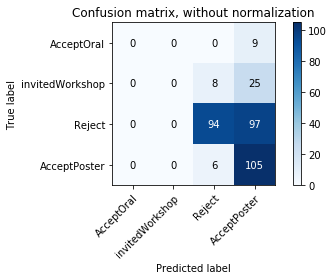

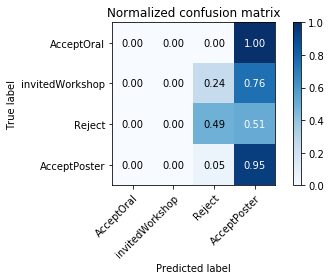

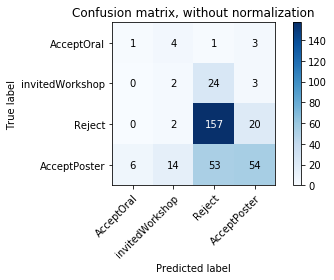

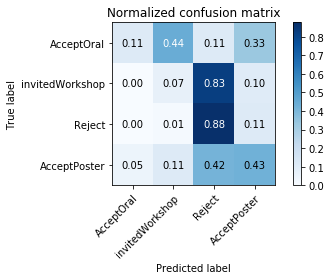

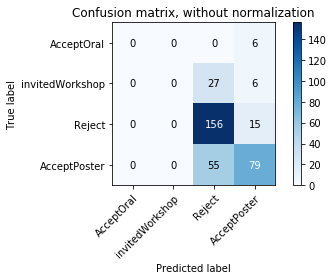

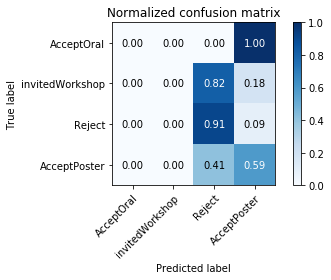

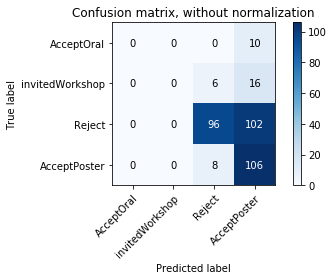

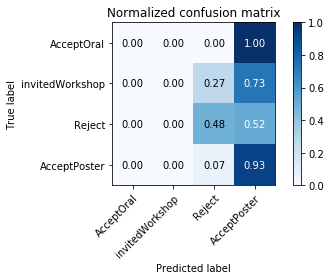

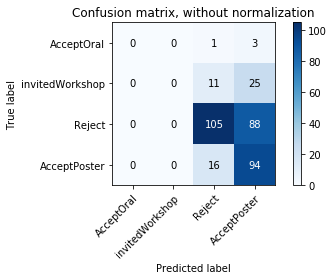

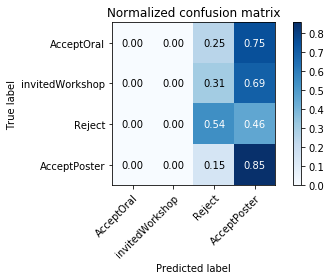

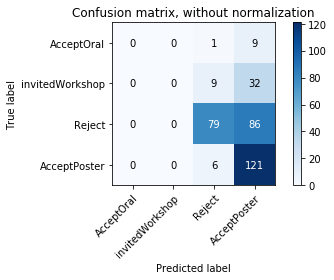

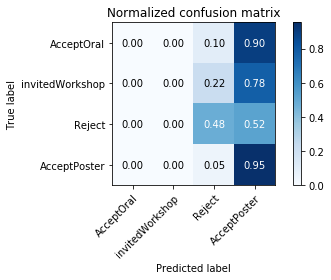

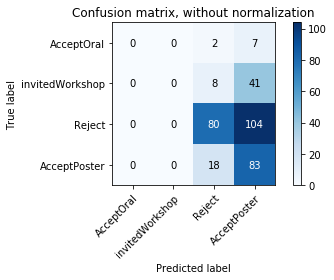

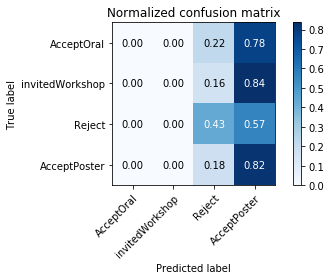

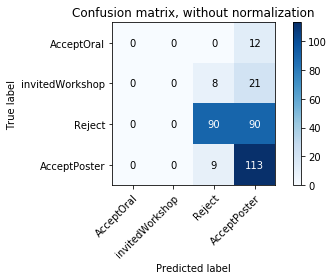

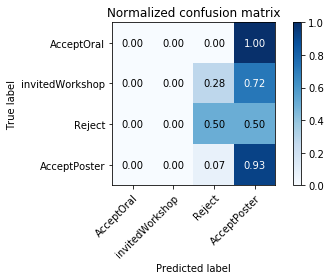

In [21]:
modelknn = KNeighborsClassifier(n_neighbors=4)

scores = []
cv = KFold(n_splits=8, random_state=420, shuffle=True)
class_names = np.array(["AcceptOral", "invitedWorkshop", "Reject","AcceptPoster"])

for train_index, test_index in cv.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  modelknn.fit(X_train,y_train)
  scores.append(modelknn.score(X_test, y_test))    
  np.set_printoptions(precision=2)
  y_pred = modelknn.fit(X_train, y_train).predict(X_test)

  # Plot non-normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, title="Confusion matrix, without normalization")
  # Plot normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title="Normalized confusion matrix")
  plt.show()

In [22]:
scores

[0.5784883720930233,
 0.622093023255814,
 0.6831395348837209,
 0.5872093023255814,
 0.5801749271137027,
 0.5830903790087464,
 0.4752186588921283,
 0.5918367346938775]

In [23]:
# Perform 10-fold cross validation
scores = cross_val_score(modelknn, X, y, cv=10)
print("Cross-validated scores:", scores)
print("Avg score: ", sum(scores)/len(scores))

Cross-validated scores: [0.41 0.57 0.52 0.67 0.61 0.57 0.39 0.49 0.54 0.55]
Avg score:  0.5320434053036996
